# Models

In [1]:
# Import libraries here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text 
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler, FunctionTransformer


%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

### Read in data from pickle

In [2]:
# read in data from my pickle
reddit = pickle.load(open("../assets/reddit.pkl", "rb"))

In [3]:
# read in additional stop words
additional_stop_words = pickle.load(open("../assets/additional_stop_words.pkl", "rb"))

### Feature engineering

Create some numeric values on my data:

1. Word Count
2. Sentiment Score

__1. Word Count per Post__

In [4]:
# Create a column for word count
reddit['word_count'] = reddit["title_selftext"].map(lambda x: len(x.split()))

__2. Sentiment Score per Post__

The code for generating sentiment score per post was shared by Daniel Kim in class.

In [96]:
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [97]:
# Write a function to get the compound sentiment scores for a post
def get_compound_sentiment(post):
    return sia.polarity_scores(post)["compound"]

In [98]:
# apply the function to the entire df
reddit["sentiment"]= reddit["title_selftext"].apply(get_compound_sentiment)

In [99]:
reddit.groupby("subreddit")["sentiment"].mean()

subreddit
LifeAfterNarcissism   -0.059316
raisedbynarcissists   -0.271773
Name: sentiment, dtype: float64

### Stem words

In [100]:
p_stemmer = PorterStemmer()

In [101]:
# I got this function from stack overflow answer here: 
# https://stackoverflow.com/questions/43795310/apply-porters-stemmer-to-a-pandas-column-for-each-word

def stem_sentences(sentence):
    tokens = sentence.split() # splits on word
    stemmed_tokens = [p_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

reddit["stemmed_words"] = reddit["title_selftext"].apply(stem_sentences)

### Set up my X and y variables

In [102]:
# 1 == "raisedbynarcissists"
# 0 == "LifeAfterNarcissism"
reddit["subreddit"] = np.where(reddit["subreddit"] == "raisedbynarcissists", 1, 0)

In [103]:
X = reddit[["stemmed_words", "word_count", "sentiment"]]
y = reddit["subreddit"]

### Split my data into train and test sets

In [104]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [105]:
# check distribution of my classes
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [106]:
# create functions to return just the columns that you care about
get_text_data = FunctionTransformer(lambda x: x["stemmed_words"], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[["word_count", "sentiment"]], validate = False)

# Logistic Regression Model

In [107]:
pipe_full = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tvec', TfidfVectorizer(ngram_range = (1,2), stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)))
            ]))
    ])),
    ('lr', LogisticRegression(penalty = "l2", C = 1, solver = "liblinear"))
])

params = {}

gs_full = GridSearchCV(pipe_full, params, cv=5)

In [108]:
gs_full.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_features',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         FunctionTransformer(accept_sparse=False,
                                                                                                             check_inverse=True,
                                                                                                             func=<function <lambda> at 0x1a36126680>,
                                                                                        

In [109]:
# save the best model
gs_full_model = gs_full.best_estimator_

In [110]:
# Print scores on test and train models
print(gs_full_model.score(X_train, y_train))
print(gs_full_model.score(X_test, y_test))

0.9012
0.7572


This model included both text data and my numeric features, word count and sentiment score. I ran my numeric features through standard scalar and then created a pipeline for my logistic regression. With a test accuracy score of 0.75, this model accurately predicts the reddit class 75% of the time. This model is overfit to my training data, since the accuracy score is higher in my training set than my test set.

### Evaluate my model

In [111]:
# generate predictions
y_preds = gs_full_model.predict(X_test)

In [112]:
# look at the coefficients 
# Dan Kim shared this code in clss!
def nice_conmat(y_test, preds, classes):
    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [113]:
# create confusion matrix
nice_conmat(y_test, y_preds, ['LifeAfterNarcissism', 'raisedbynarcissists'])

Accuracy Score: 0.7572


,Predicted LifeAfterNarcissism,Predicted raisedbynarcissists
Actual LifeAfterNarcissism,1848,652
Actual raisedbynarcissists,562,1938


In [114]:
# pull coefficients for model
coefs = gs_full_model.named_steps["lr"].coef_[0]

In [115]:
# get feature names
features = ["word_count", "sentiment"]
features.extend(gs_full_model.named_steps['features'].transformer_list[1][1].named_steps['tvec'].get_feature_names())

In [118]:
# create a dataframe of features + coefficients
simple_df = pd.DataFrame({"features": features,
             "coefficients": coefs, 
            "absolute_coefs": np.abs(coefs)})

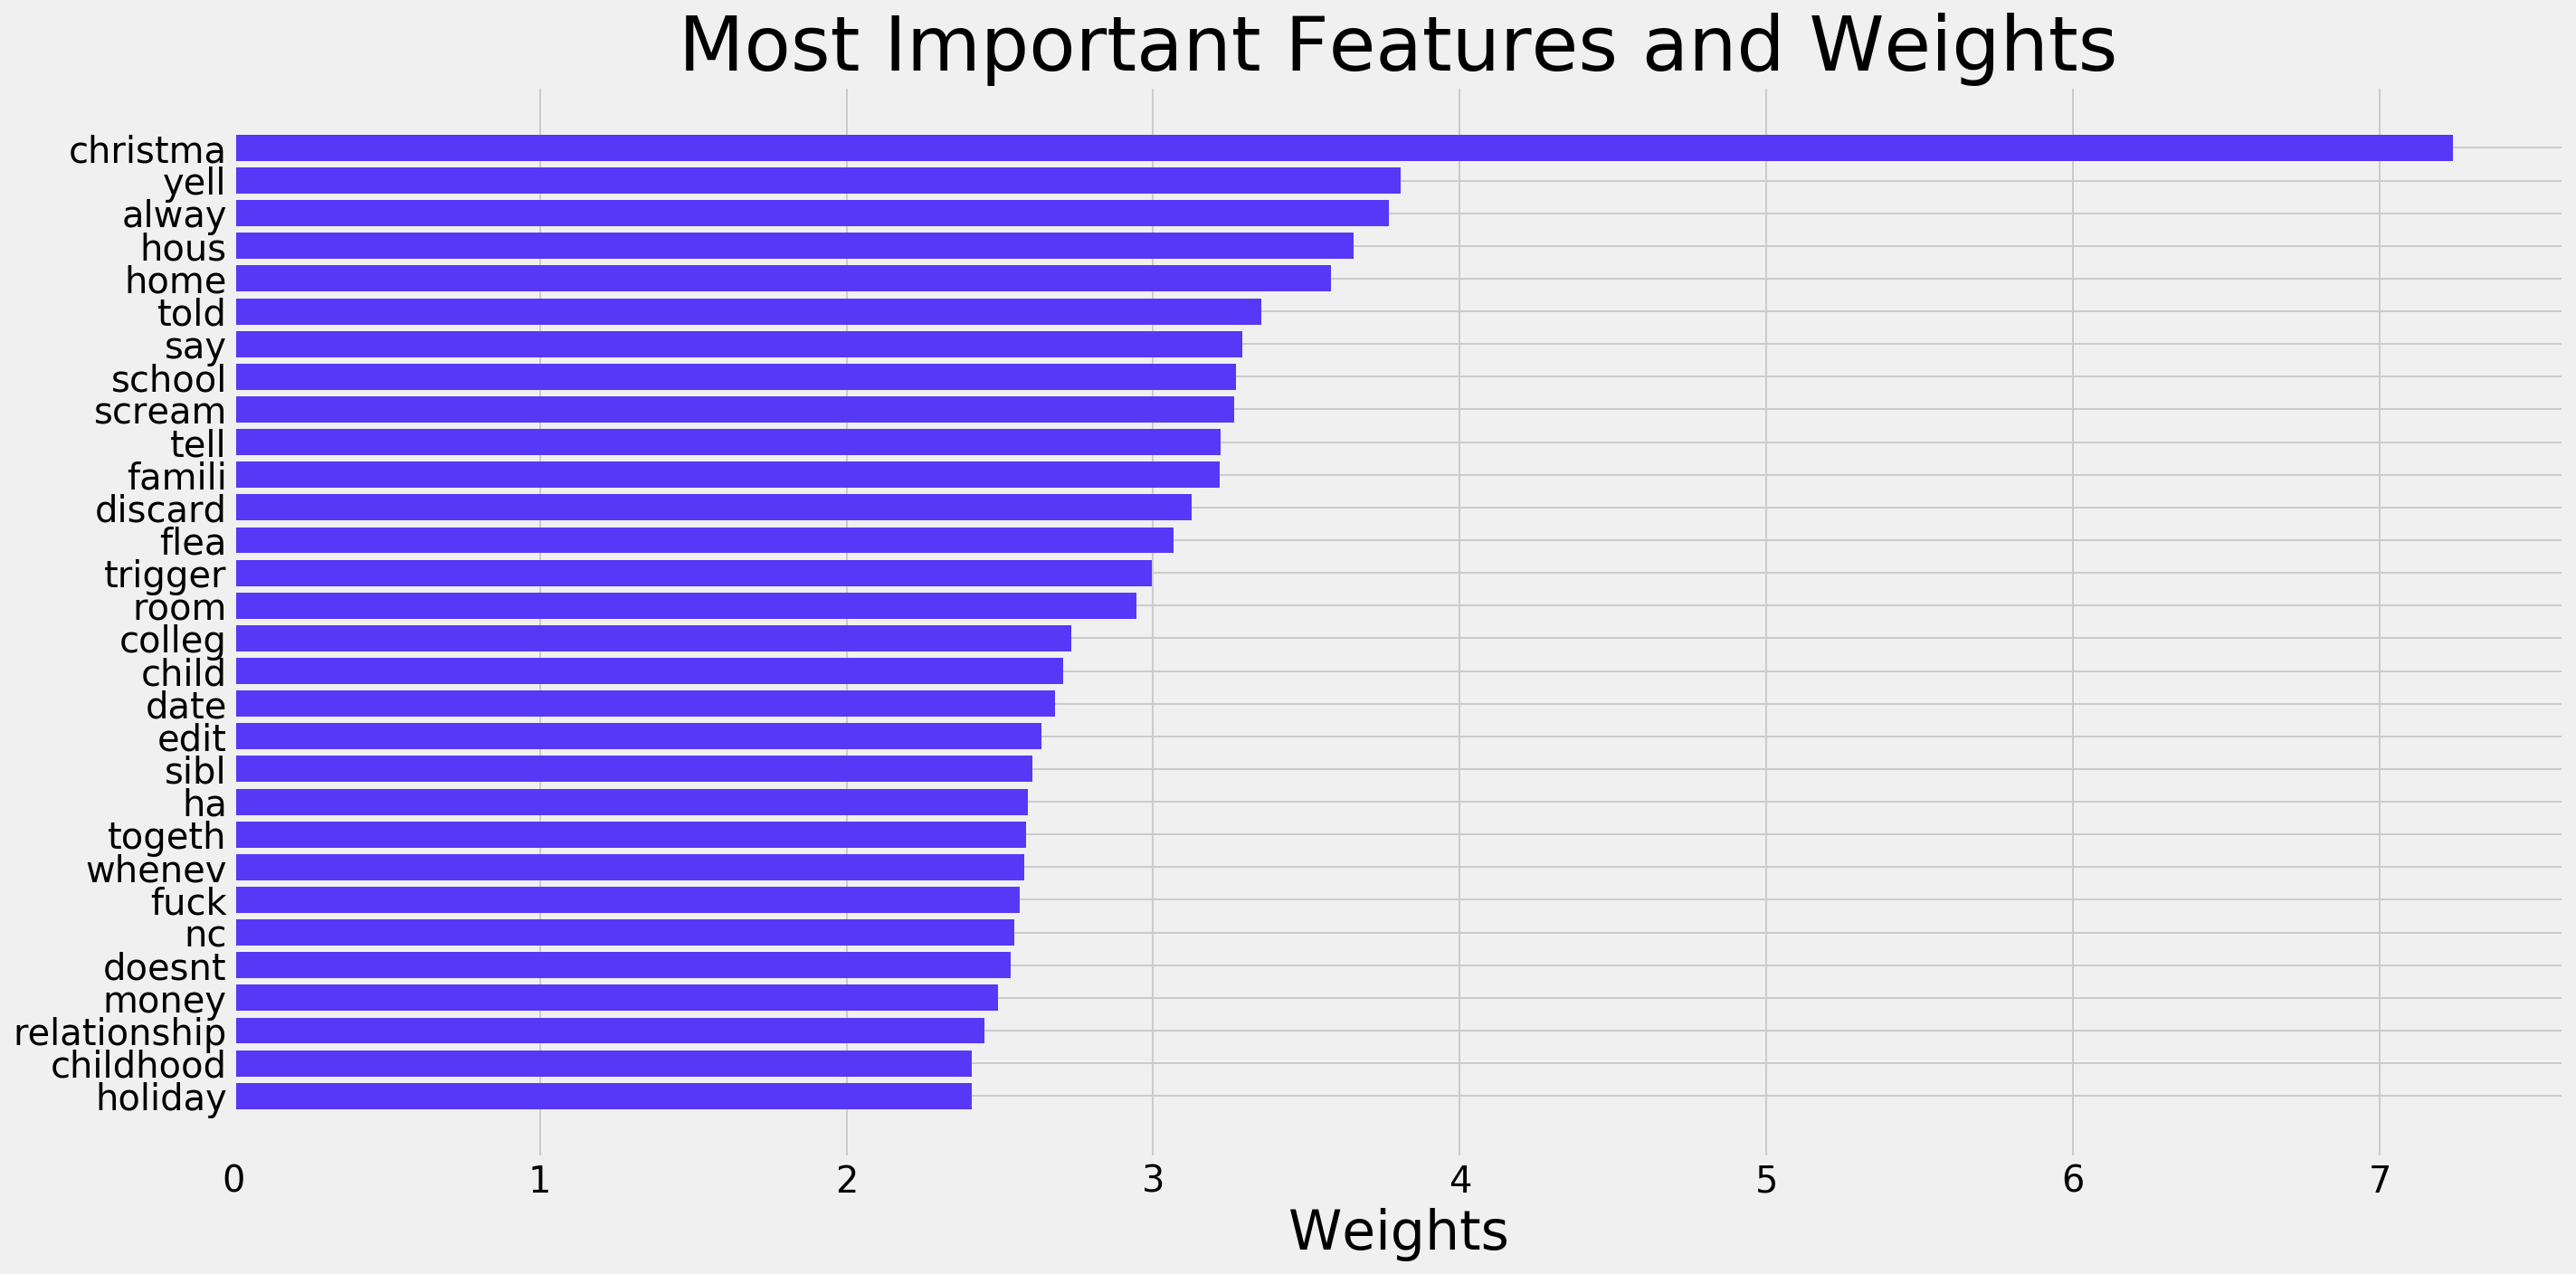

In [121]:
# graph in bar chart
beta_df = simple_df.sort_values("absolute_coefs", ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('features')
beta_df = beta_df[beta_df['absolute_coefs'] != 0] #removes coefficients of 0
beta_df.head(20)
weights = beta_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = "#5738f6")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title("Most Important Features and Weights", fontsize=42)
plt.tight_layout()
plt.savefig('../plots/feature_coefs.png')

The biggest predictor in this model is the word "Christmas." Holding all else constant, the appearance of the word "Christmas" increases the log odds of the post being in raisedbynarcissists by 7.23.

# Random forest model

In [126]:
# Set up my X and y variables
X = reddit["stemmed_words"]
y = reddit["subreddit"]

In [127]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [128]:
# instantiate model
pipe_rf = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("rf",RandomForestClassifier(random_state = 42))
])

In [129]:
# set up my hyperparameters
rf_params = {
    "tvec__max_features": [500], # max features 100 and 500
    "tvec__ngram_range": [(1,2)], # ngram default and ngrams 2 and 3
    "tvec__stop_words": [text.ENGLISH_STOP_WORDS.union(additional_stop_words)], # remove stop words and keep stop words  
    "rf__n_estimators": [125],
    "rf__max_depth": [6],
    "rf__max_features": ["auto"]
}

In [130]:
# Initiate grid search
gs_rf = GridSearchCV(
    pipe_rf, 
    param_grid = rf_params,
    cv = 5
)

In [131]:
# fit model
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [133]:
# save best model
gs_model_rf = gs_rf.best_estimator_

In [30]:
# Print scores on test and train models
print(gs_model_rf.score(X_train, y_train))
print(gs_model_rf.score(X_test, y_test))

0.7408
0.7134


This model only included text data for my features. I ran a random forest with max 500 features, 125 estimators, and max depth of 6. With a test accuracy score of 0.71, this model accurately predicts the reddit class 71% of the time. The difference between the test and train scores was smaller in my random forest model than my ridge regression. While this model has a lower accuracy score, it might be better for working with new datasets because it has less variance.